In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten, Dense, Concatenate
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical

In [3]:
# Load data
metadata_path = './id_metadata.csv'
listening_history_path = './lh_reduced.csv'
metadata_df = pd.read_csv(metadata_path, delimiter='\t')
df = pd.read_csv(listening_history_path)
df.head()

,Unnamed: 0,user,song,timestamp
0,0,user_007XIjOr,DaTQ53TUmfP93FSr,2019-02-20 12:28
1,1,user_007XIjOr,dGeyvi5WCOjDU7da,2019-02-20 12:35
2,2,user_007XIjOr,qUm54NYOjeFhmKYx,2019-02-20 12:48
3,3,user_007XIjOr,FtnuMT1DlevSR2n5,2019-02-20 12:52
4,4,user_007XIjOr,LHETTZcSZLeaVOGh,2019-02-20 13:09


In [4]:
unique_names_song = df.song.unique()
unique_names_user = df.user.unique()
unique_names_song.shape, unique_names_user.shape

((23256,), (282,))

In [5]:
# Calculate song popularity
song_popularity = df['song'].value_counts() / len(unique_names_song)
df['song_popularity'] = df['song'].map(song_popularity)

# Create an empty interaction matrix
interaction_matrix = np.zeros((df['user'].nunique(), len(unique_names_song)))

# Map users and songs to matrix indices
user_indices = {user: idx for idx, user in enumerate(df['user'].unique())}
song_indices = {song: idx for idx, song in enumerate(unique_names_song)}

# Create a DataFrame from the interaction matrix
user_ids, song_ids, interactions = [], [], []
for user in user_indices:
    for song in song_indices:
        user_ids.append(user_indices[user])
        song_ids.append(song_indices[song])
        interactions.append(interaction_matrix[user_indices[user], song_indices[song]])

interaction_df = pd.DataFrame({'user_id': user_ids, 'song_id': song_ids, 'interaction': interactions})

In [7]:
user_encoder = LabelEncoder()
song_encoder = LabelEncoder()
df['user_id'] = user_encoder.fit_transform(df['user'])
df['song_id'] = song_encoder.fit_transform(df['song'])

N = df.user_id.nunique() # Number of users
M = df.song_id.nunique() # Number of songs

print(N , M)

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(interaction_df, test_size=0.2, random_state=42)
df_train.shape

282 23256


(5246553, 3)

Epoch 1/25
40989/40989 [==============================] - 303s 7ms/step - loss: 7.6077e-04 - mse: 7.6077e-04 - val_loss: 4.4247e-04 - val_mse: 4.4247e-04
Epoch 2/25
40989/40989 [==============================] - 300s 7ms/step - loss: 3.2838e-04 - mse: 3.2838e-04 - val_loss: 2.3312e-04 - val_mse: 2.3312e-04
Epoch 3/25
40989/40989 [==============================] - 300s 7ms/step - loss: 1.7425e-04 - mse: 1.7425e-04 - val_loss: 1.2926e-04 - val_mse: 1.2926e-04
Epoch 4/25
40989/40989 [==============================] - 301s 7ms/step - loss: 9.9092e-05 - mse: 9.9092e-05 - val_loss: 7.6761e-05 - val_mse: 7.6761e-05
Epoch 5/25
40989/40989 [==============================] - 303s 7ms/step - loss: 6.1443e-05 - mse: 6.1443e-05 - val_loss: 5.0152e-05 - val_mse: 5.0152e-05
Epoch 6/25
40989/40989 [==============================] - 314s 8ms/step - loss: 4.2250e-05 - mse: 4.2250e-05 - val_loss: 3.6464e-05 - val_mse: 3.6464e-05
Epoch 7/25
40989/40989 [==============================] - 324s 8ms/step - lo

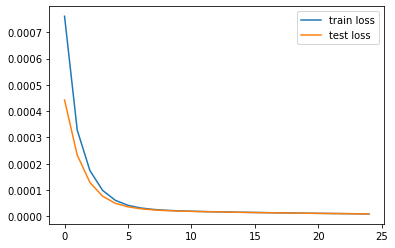

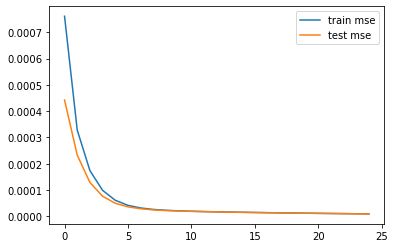

In [62]:
K = 50  # Latent dimensionality
mu = df_train.interaction.mean()  # Mean interaction for normalization
epochs = 25
reg = 0.1  # Regularization penalty

u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)


##### main branch
u_bias = Embedding(N, 1)(u) # (N, 1, 1)
m_bias = Embedding(M, 1)(m) # (N, 1, 1)
x = Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)
x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)


##### side branch
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)
y = Concatenate()([u_embedding, m_embedding]) # (N, 2K)
y = Dense(400)(y)
y = Activation('elu')(y)
y = Dropout(0.3)(y)
y = Dense(400)(y)
y = Activation('elu')(y)
y = Dropout(0.3)(y)
y = Dense(1)(y)


##### merge
x = Add()([x, y])

model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  #optimizer=Adam(lr=0.001),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

# Now, train the model
r = model.fit(
  x=[df_train.user_id.values, df_train.song_id.values],
  y=df_train.interaction.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.user_id.values, df_test.song_id.values],
    df_test.interaction.values - mu
  )
)

plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['mse'], label="train mse")
plt.plot(r.history['val_mse'], label="test mse")
plt.legend()
plt.show()

In [84]:
user_ids_test = df_test.user_id.values
song_ids_test = df_test.song_id.values

# Choose a specific user
specific_user_id = user_ids_test[5]  # For example, taking the first user in the test set

# Prepare input data: Repeat the specific user ID for each song
user_input = np.array([specific_user_id] * M)  # M is the total number of songs

# All song IDs
song_input = np.array(range(M))

# Make predictions for this user with all songs
predicted_interactions = model.predict([user_input, song_input])

# Convert predictions back to the original scale
predicted_interactions = predicted_interactions.flatten() + mu

top_10_indices = np.argsort(predicted_interactions)[::-1][:10]

# Get the original song IDs for these top 10 songs
top_10_song_ids = song_encoder.inverse_transform(top_10_indices)

# Output the recommended songs
print("Top 10 recommended song IDs for user", specific_user_id, "are:", top_10_song_ids)

727/727 [==============================] - 1s 2ms/step
Top 10 recommended song IDs for user 270 are: ['l1R2SCyFUPiIYB19' 'pezvy1q7lK7X5NpK' '5utAtxO4Uvjv63gZ'
 'Mqu1j2KwTVHWY9KC' 'mvXKgYzhUQIMIly9' '5DK0yRIW8JOujBLo'
 'DvocIPFqnF91fW4v' '1Czn5lNChBDhqaYq' '87Ct1HWIQ8QBLuP9'
 '0gvNASK72uWxpQiT']


In [85]:
#original_user_ids = user_encoder.inverse_transform(df.user)
df[df.song == top_10_song_ids[0]]

,Unnamed: 0,user,song,timestamp,song_popularity,user_id,song_id
15480,15480,user_09y1WGSJ,l1R2SCyFUPiIYB19,2019-01-12 18:52,0.000129,41,17635
16386,16386,user_0BX9L05X,l1R2SCyFUPiIYB19,2019-02-13 18:43,0.000129,43,17635
85806,85806,user_11DRPTDc,l1R2SCyFUPiIYB19,2019-01-24 18:41,0.000129,241,17635


In [86]:
id_information = pd.read_csv('./id_information.csv', sep='\t')
id_information.head()

,id,artist,song,album_name
0,0009fFIM1eYThaPg,Cheryl,Rain on Me,3 Words
1,0010xmHR6UICBOYT,Oddisee,After Thoughts,The Beauty in All
2,002Jyd0vN4HyCpqL,Blue Öyster Cult,ME 262,Secret Treaties
3,006TYKNjNxWjfKjy,Rhapsody,Flames of Revenge,Legendary Years (Re-Recorded)
4,007LIJOPQ4Sb98qV,The Chameleons,Nostalgia,What Does Anything Mean? Basically (2009 Remas...


In [93]:
id_information[id_information.id == top_10_song_ids[3]]

,id,artist,song,album_name
40274,Mqu1j2KwTVHWY9KC,Altered Images,Happy Birthday,HAPPY BIRTHDAY


In [88]:
df[df.user_id == specific_user_id].song.unique()

array(['kJeDKXoAmvMbt0aw', 'ELZZk6mUQosK2rgf', '3ovo5zTCqINDQLVE',
       'TfDcisAgz7sLIi7w', 'tkwc6wiBvkiVYm8F', 'OlHLkCDZ7IGTTHwO',
       'hKElxMyzEVpytG4E', 'BNccjmquagZc4cFn', 'qwAR3KymFSkwc7BO',
       'KzvxC6Z4nTwd01VW', 'd2OMjn1XiPXTwz7v', 'bsrJbdryqNzHTJdj',
       'IPRnNtIdGOSuGWam', 'NwDPvS4wmJTviUaT', 'dlMwQgylGglSCeUQ',
       'tGIM8sloXbzyY7FL', 'kdT7sQ5kDQ3pZZKg', 'IPz3o9EAZyjKdup5',
       'Ht77zi3Kq2oQjLCs', 'pUrOPe2PERkHOu7n', 'o2LcK38b4mFLa55g',
       '7my30NrFPVdYPQjQ', 'CoGHDHi233BbLyDo', 'Yspm1Y9yTgWd3maJ',
       'ebu87AQPOzBXizSM', 'sG6GtcCQtywRdAc9', 'Q3dHaYbJvJqADyO0',
       'PlpohkhZ3mHRIFUw', 'ob3rJvNvmxEBUgrM', 's5gyDjeyG1xi4eeI',
       'l4GKDRNpB5K0gYbl', 'LZXd9FJwCYRq64Hh', 'rpEHshcYbI4nTWzP',
       'VxZ9ksJ2VFnjq3sQ', 'hUX2rxUzweCf1Q6s', '0X9aluHlz6iKWBMR',
       'BV5aZd8ZACEwaMyi', 'uWmyuAJfXZo8eQ1s', '3AFJhhbI2bMOuY9r',
       'OKtdWyDbmVm4DhBW', 'NlIkh6a07aJUvtzd', 'Ms7tvtmnfNd6gKFi',
       '4LgU0HMsp3HcCiCp', 'EHMaLL1Vwb0kR5cw', 'pKa8tqv3wZORbV

In [90]:
id_information[id_information.id == '9kA5LV8gJZ89jfkE']

,id,artist,song,album_name
17155,9kA5LV8gJZ89jfkE,Angèle,Ta Reine,Brol
